# Setting multiple Dirichlet condition

In the previous section, we used a single function to $u_d$ to setting Dirichlet conditions on two parts of the boundary. However, it is often more practical to use multiple functions, one for each subdomain of the boundary. We consider a similar example to [the previous example](./neumann_dirichlet_code) and redefine it consist of two Dirichlet boundary conditions

$$
-\nabla^2 u =f \quad \text{in } \Omega,
$$

$$
u=u_L \quad \text{on } \Lambda_D^L
$$

$$
u=u_R \quad \text{on } \Lambda_D^R
$$

$$
-\frac{\partial u}{\partial n} = g \quad \text{on } \Lambda_N.
$$
Here, $\Lambda_D^L$ is the left boundary $x=0$,  while $\Lambda_D^R$ is the right boundary $x=1$.
We note that $u_L(y)=1+2y^2$, $u_R(y)=2+2y^2$ and $g(y)=-4y$ using the same analytical example as in the previous section.

We start by defining the mesh, function space and variational formulation as in the previous exercise

In [1]:
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant, Function, FunctionSpace,
                         assemble_scalar, dirichletbc, form, locate_dofs_geometrical)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_unit_square
from dolfinx.plot import vtk_mesh

from mpi4py import MPI
from ufl import SpatialCoordinate, TestFunction, TrialFunction, dot, dx, ds, grad

import numpy as np
import pyvista


def u_exact(x):
    return 1 + x[0]**2 + 2 * x[1]**2


mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)
V = FunctionSpace(mesh, ("Lagrange", 1))
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) * dx
x = SpatialCoordinate(mesh)
g = - 4 * x[1]
f = Constant(mesh, default_scalar_type(-6))
L = f * v * dx - g * v * ds

We next mark the two boundaries separately, starting with the left boundary

In [2]:
dofs_L = locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
u_L = Function(V)
u_L.interpolate(lambda x: 1 + 2 * x[1]**2)
bc_L = dirichletbc(u_L, dofs_L)

Note that we have used `lambda`-functions to compactly define the functions returning the subdomain evaluation and function evaluation. We can use a similar procedure for the right boundary condition, and gather both boundary conditions in a vector `bcs`.

In [3]:
dofs_R = locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 1))
u_R = Function(V)
u_R.interpolate(lambda x: 2 + 2 * x[1]**2)
bc_R = dirichletbc(u_R, dofs_R)
bcs = [bc_R, bc_L]

We are now ready to again solve the problem, and check the $L^2$ and max error at the mesh vertices.

In [4]:
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

V2 = FunctionSpace(mesh, ("Lagrange", 2))
uex = Function(V2)
uex.interpolate(u_exact)
error_L2 = assemble_scalar(form((uh - uex)**2 * dx))
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.x.array
uex_1 = Function(V)
uex_1.interpolate(uex)
u_ex_vertex_values = uex_1.x.array
error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)
print(f"Error_L2 : {error_L2:.2e}")
print(f"Error_max : {error_max:.2e}")

Error_L2 : 5.27e-03
Error_max : 2.44e-15


## Visualization
To visualize the solution, run the script with in a Jupyter notebook with `off_screen=False` or as a python script with `off_screen=True`.

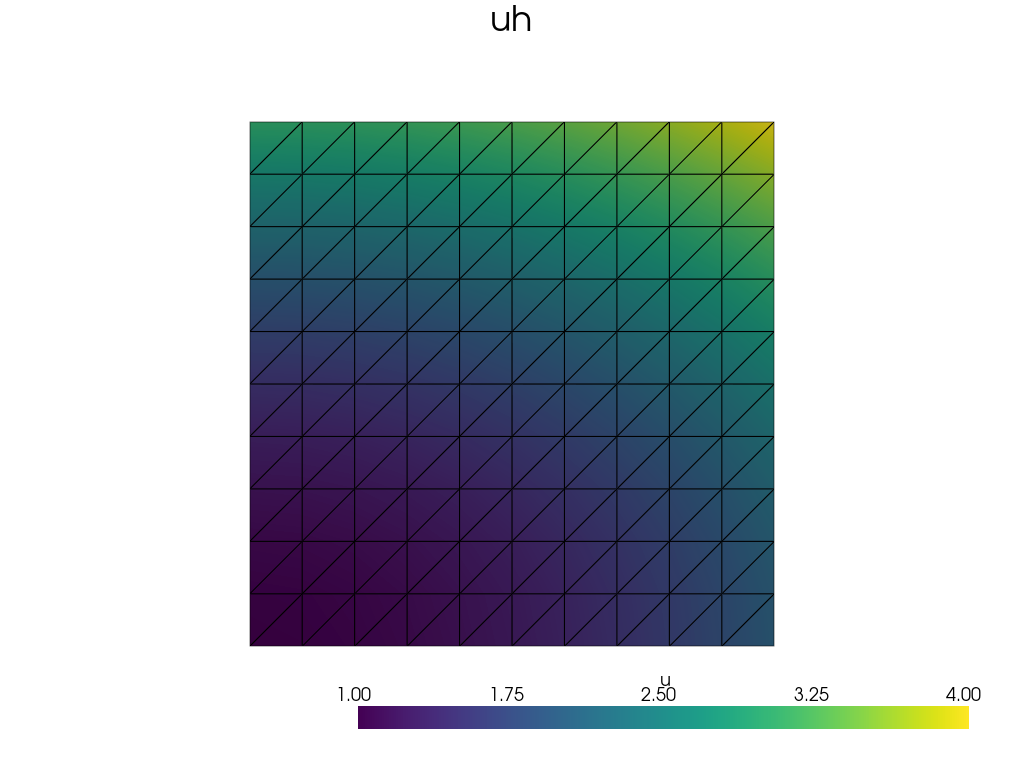

In [5]:
pyvista.start_xvfb()
pyvista_cells, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = uh.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_text("uh", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("multiple_dirichlet.png")